# EIT-CEM

In [1]:
#Fixing paths
import sys
from FEITTV_codes.module1_mesh import *
from FEITTV_codes.module2_forward import *
from FEITTV_codes.module3_inverse import *
from FEITTV_codes.module4_auxiliar import *
from scipy.sparse import csr_matrix

#Importing modules
#from FEIT_onefile import *
from math import pi
import scipy
import pickle
%matplotlib inline

In [2]:
"Definições Básicas do espaço."
r=14            #Radi
L=16           #Number of Electrodes
per_cober=0.454728409  #Perc. area of elec. on boundary
rotate=pi/2-0.0892857143183109       #Rotation

ele_pos=electrodes_position(L, per_cober, rotate, anticlockwise=False) #Eletrodes position object

## Checking electrode dimension

In [3]:
i=0
thetai=(ele_pos.position[i][0])
thetaf=(ele_pos.position[i][1])
elec_lenght=(thetaf-thetai)*r
print("Electrode {} lenght is: {} cm".format(i, elec_lenght))

Electrode 0 lenght is: 2.500000000912705 cm


N: 681, M: 160, K:1200


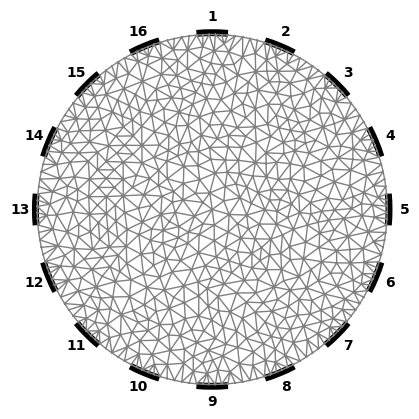

In [4]:
#input
refine_n=15 #Refinement parameter
n_in=6   #Number of vertex on electrodes
n_out=4   #Number of vertex on gaps

mesh=MyMesh(r=r, n=refine_n, n_in=n_in, n_out=n_out, electrodes_obj=ele_pos)
plot_electrodes(mesh, figsize=(5,5), fontsize=10)

#Mesh config
bmesh=BoundaryMesh(mesh, 'exterior', order=True)
print("N: {}, M: {}, K:{}".format(mesh.num_vertices(), bmesh.num_vertices(), mesh.num_cells()))

## Experiment data

In [5]:
def assemble_L(mesh):
    D = mesh.topology().dim()
    mesh.init() # Build connectivity between facets and cells
    cellsnum=mesh.num_cells()
    L = []
    for edge in edges(mesh):
        CellsInEdge = edge.entities(D)
        L_Line = np.zeros(cellsnum)
        if len(CellsInEdge)==2:  #Only interior edges.
            L_Line[CellsInEdge[0]], L_Line[CellsInEdge[1]] = +edge.length(), -edge.length()
            L.append(np.copy(L_Line))
    return np.array(L)
Lm=assemble_L(mesh)
from scipy.sparse import csr_matrix
Lm=csr_matrix(Lm)
print(np.shape(Lm))


(1720, 1200)


In [6]:
solverconfig_dict= { 
            #General Parameters
            "step_limit": 30,
            "weight_value": True,
            "innerstep_limit": 10000,
            #General newton method parameters
            "mu_i":0.7,
            "mumax":0.999,
            "nu":0.98,
            "R":0.98,
            "z":np.ones(L)*0.07825,
            "background":0.92959,           
}

In [7]:
#LM = Levenberg-Marquadt
list_exps = ["1_2_TV", "2_3_TV", "4_1_TV"]
experiments = {}
for exp in list_exps: 
    experiments[exp] = {} 
    experiments[exp]["config"] = solverconfig_dict.copy()
    experiments[exp]["results"] = {}

#
TV_param = {
    "inner_method": 'LMrrTV', 
    "LMrrTV_eta": 0.25,      #eta
    #Geral parameters
    "LMrrTV_reduc":0.05,   #Reduction grad norm (stop  criteria)
    "LMrrTV_mu": 0.01,     #Tikhonov weight
    "LMrrTV_L": Lm,         #L matrix
    "LMrrTV_alpha_method": "--",    #beta
    #Specific
    "LMrrTV_p": 1.01,        #p_space
    "LMrrTV_tolLm": 1E15,   #Tolerance
    "LMrrTV_beta": 1E-4,    #beta  
    #Interval
    "LMrrTV_ph": 0.01,     #p hat (bottom curve)
    "LMrrTV_phh": 0.7,     #p hathat (top curve)
    "LMrrTV_a1":2/3,       #Increasing factor
    "LMrrTV_a2":2,      #Decreasing factor
    "LMrrTV_phInner":2/3,  #p hat inner bottom curve
    "LMrrTV_phhInner":1/3, #p hathat inner top curve
    #Usual
    "LMrrTV_method":"gradient_eps",
    "LMrrTV_grad_step":0.2E-3,
    "LMrrTV_alpha":5,#alpha 
}
#1_2_TV
experiments["1_2_TV"]["config"].update(TV_param)
experiments["1_2_TV"]["config"]["LMrrTV_grad_step"]=0.3E-3
experiments["1_2_TV"]["config"]["LMrrTV_alpha"]=2
experiments["1_2_TV"]["config"]["data"]="datamat_1_2"

experiments["2_3_TV"]["config"].update(TV_param)
experiments["2_3_TV"]["config"]["LMrrTV_grad_step"]=0.3E-3
experiments["2_3_TV"]["config"]["LMrrTV_alpha"]=2
experiments["2_3_TV"]["config"]["data"]="datamat_2_3"

experiments["4_1_TV"]["config"].update(TV_param)
experiments["4_1_TV"]["config"]["LMrrTV_grad_step"]=0.3E-3
experiments["4_1_TV"]["config"]["LMrrTV_alpha"]=2
experiments["4_1_TV"]["config"]["data"]="datamat_4_1"



In [9]:
"Object"
VD=FiniteElement('CG',mesh.ufl_cell(),1) #Espaço da solução
for key, experiment in experiments.items():
    print(key)
    dataname = experiments[key]["config"]["data"]
    #Load experimental data
    mat = scipy.io.loadmat("datamat/"+dataname)
    Uel=mat.get("Uel").T
    CP=mat.get("CurrentPattern").T

    #Selecting Potentials
    Uel_f=Uel[64:] #Matrix of measuarements
    Uel_converted=np.zeros_like(Uel_f)

    #Convert type of data
    for index, potential in enumerate(Uel_f): 
        Uel_converted[index]=ConvertingData(potential, method="KIT4")
    list_U0=Uel_converted.flatten() #Matrix to vector

    #Current
    I_all=CP[64:]/sqrt(2) #A constant to match with the background cond +/-
    l=np.shape(I_all)[0] #Number of experiments = 15

    #Noise Estiamtive
    delta = EstimateDelta(list_U0, I_all)
    noise_level_exp = delta/np.linalg.norm(list_U0)
    print("Noise level (%): ", noise_level_exp*100)

    z=experiment["config"]["z"]
    cond=experiment["config"]["background"]
    eta = experiment["config"]["LMrrTV_eta"]
    InverseObject=InverseProblem(mesh, list_U0, I_all, z)
    
    #First guess
    guess_r=np.ones(mesh.num_cells())*cond
    InverseObject.set_firstguess(guess_r)

    #"Solver Parameters"
    tau=1.1*(1+eta)/(1-eta)
    InverseObject.set_solverconfig(**experiment["config"], tau=tau, noise_level=noise_level_exp)

    #"Noise Parameters"
    print(f"Discrepance stop {tau*noise_level_exp*100}% residue")

    #Call Solver
    InverseObject.solve_inverse()

    #Getting results
    experiment["results"]["res_vec"]=np.copy(InverseObject.res_vec)
    experiment["results"]["error_vec"]=np.copy(InverseObject.error_vec)
    experiment["results"]["gamma_k"]=InverseObject.gamma_all
    experiment["results"]["delta"]=noise_level_exp
    experiment["results"]["data0_vec"] = list_U0
    experiment["results"]["lastU0_vec"] = InverseObject.list_U

    save_it=True
    if save_it:
            for key, experiment in experiments.items():
                    with open('data/datamat_{}.data'.format(key), 'wb') as config_dictionary_file:
                            pickle.dump(experiment, config_dictionary_file)

1_2_TV
Noise level (%):  0.4235990100461563
Discrepance stop 0.7765981850846199% residue
Residue (%)= 15.01403143367924  step: 0 Inner step:  0
mu_n 0.7
grad0=1.9575, grad=1.9451, alpha=2
grad0=1.9575, grad=1.0490, alpha=2
grad0=1.9575, grad=0.6364, alpha=2
grad0=1.9575, grad=0.3968, alpha=2
grad0=1.9575, grad=0.2552, alpha=2
grad0=1.9575, grad=0.1694, alpha=2
grad0=1.9575, grad=0.1155, alpha=2
ck=0.439, res=0.655, dk=1.179
Residue (%)= 6.724289927941256  step: 1 Inner step:  6449
mu_n 0.7
grad0=0.1972, grad=0.1883, alpha=1.3333333333333333
grad0=0.1972, grad=0.0302, alpha=1.3333333333333333
grad0=0.1972, grad=0.0101, alpha=1.3333333333333333
ck=0.226, res=0.597, dk=0.537
grad0=0.3944, grad=0.3841, alpha=2.6666666666666665
grad0=0.3944, grad=0.1037, alpha=2.6666666666666665
grad0=0.3944, grad=0.0617, alpha=2.6666666666666665
grad0=0.3944, grad=0.0436, alpha=2.6666666666666665
grad0=0.3944, grad=0.0331, alpha=2.6666666666666665
grad0=0.3944, grad=0.0262, alpha=2.6666666666666665
grad0=0


## Test section

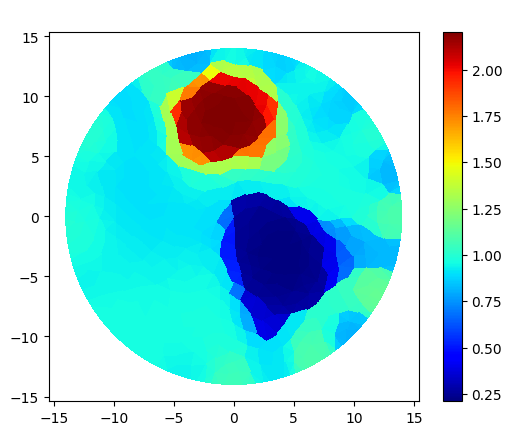

In [10]:
#Plot
Q_DG = FunctionSpace(mesh, "DG", 0)
gamma_k = Function(Q_DG)

gamma_k_vec=np.copy(InverseObject.gamma_all[-1])
gamma_k.vector()[:]=gamma_k_vec#-np.log(gamma_k_vec)/np.log(cond)
gamma_k=plot_figure(gamma_k, name=" ", map='jet')

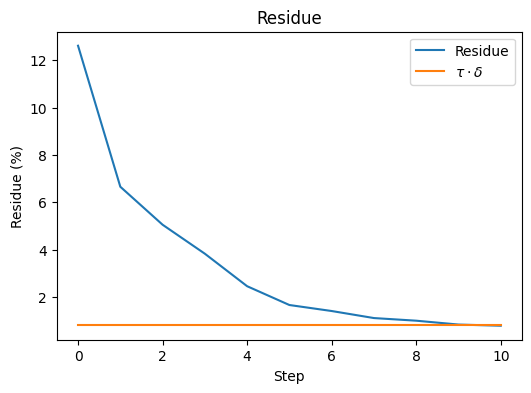

In [11]:
#Residue Curve
res=np.copy(InverseObject.res_vec)

plt.figure(figsize=(6, 4))
plt.ylabel('Residue (%)');
plt.xlabel('Step');
plt.title('Residue');
plt.plot()
plt.plot(res, label="Residue");
plt.plot(np.ones(len(res))*tau*noise_level_exp*100, label=r"$\tau \cdot \delta$");
plt.legend()
#plt.savefig("figures/{}/Residue.png".format(exp_name))
plt.show()